In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost

# from functions import col_analytics, get_score, res_2_csv

### Внутренние функции

In [313]:
def recode_column(df_column, threshold):
    value_counts = df_column.value_counts(normalize=True)
    recoded_column = df_column.apply(lambda x: 1 if value_counts[x] >= threshold else 0)
    return recoded_column

In [314]:
def col_analytics(col, normalize=None):
    print(f'Число NaN: {subm_df[col].isna().sum()}')
    print(f'Число уникальный значений: {subm_df[col].nunique()}')
    print(subm_df[col].value_counts(normalize=normalize))
    sns.histplot(subm_df[col])

In [315]:
def recode_category(column, threshold, df):
    # Calculate the frequency of each category
    value_counts = df[column].value_counts(normalize=True)
    
    # Recode values below the threshold to "Other"
    df[column] = df[column].apply(lambda x: x if value_counts[x] >= threshold else 'Other')  
    return df[column]

### Данные

#### Загрузка данных

In [316]:
df = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
subm_df=pd.concat([df,test],axis=0)
subm_df.drop('SalePrice', axis=1, inplace=True)
y_train=df['SalePrice']

In [317]:
df.shape, test.shape, subm_df.shape

((1460, 81), (1459, 80), (2919, 80))

График цены ниже показывает, что следует модель строить для логарифмированной цены

In [318]:
# df_num = subm_df.select_dtypes(include = ['float64', 'int64', 'int8'])
# df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Будем удалять те параметры, где "перекос" в сторону конкретной категории / значения составляет более 85%

In [319]:
# # df_cat is a DataFrame containing your categorical variables
# df_cat = subm_df.select_dtypes(include = ['object'])

# # Get the number of categorical columns
# num_cols = df_cat.shape[1]

# # Calculate the number of rows and columns for the subplot grid
# num_rows = (num_cols - 1) // 5 + 1
# num_cols = min(num_cols, 5)

# # Create a figure with subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# # Flatten the axs array if it's 2D
# if num_rows > 1:
#     axs = axs.ravel()

# # Plot countplots for each categorical variable
# for i, col in enumerate(df_cat.columns):
#     sns.countplot(x=col, data=df_cat, ax=axs[i])
#     axs[i].set_title(f'Countplot of {col}')
#     axs[i].set_xlabel(col)
#     axs[i].set_ylabel('Count')

# # Remove any empty subplots
# for i in range(len(df_cat.columns), len(axs)):
#     axs[i].axis('off')

# # Adjust the layout to prevent overlap of labels
# plt.tight_layout()

# # Show the plots
# plt.show()

Аналогично, будем удалять те фичи, где "перекос" в сторону конкретной категории / значения составляет более 85%

#### Предобработка данных

In [320]:
subm_cols = subm_df.columns.to_list()

In [321]:
subm_df.isna().sum().to_dict()

{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 4,
 'LotFrontage': 486,
 'LotArea': 0,
 'Street': 0,
 'Alley': 2721,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 2,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 1766,
 'MasVnrArea': 23,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 81,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinType1': 79,
 'BsmtFinSF1': 1,
 'BsmtFinType2': 80,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 1,
 'TotRmsAbvGrd': 0,
 'Functional': 2,
 

Удаляем ненужные фичи (много пропусков, слишком большое смещение 85%+ в одну категорию), далее будем разбираться с nan

In [322]:
col_2_delete = ['LowQualFinSF', '2ndFlrSF', 'BsmtHalfBath', 'Functional', 'WoodDeckSF', 
                'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'CentralAir', 'Electrical', 'GarageQual', 
                'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'KitchenAbvGr', 'SaleType', 'Street', 'Alley', 
                'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Neighborhood', 'Heating', 'GarageCond', 'PavedDrive']
len(col_2_delete)

28

In [323]:
# удаляем колонки
subm_df = subm_df.drop(columns=col_2_delete)

In [324]:
subm_df.isna().sum().to_dict()

{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 4,
 'LotFrontage': 486,
 'LotArea': 0,
 'LotShape': 0,
 'LandContour': 0,
 'LotConfig': 0,
 'Condition1': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 1766,
 'MasVnrArea': 23,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 81,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinType1': 79,
 'BsmtFinSF1': 1,
 'BsmtFinType2': 80,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'HeatingQC': 0,
 '1stFlrSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 2,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenQual': 1,
 'TotRmsAbvGrd': 0,
 'Fireplaces': 0,
 'FireplaceQu': 1420,
 'GarageType': 157,
 'GarageYrBlt': 159,
 'GarageFinish': 159,
 'GarageCars': 1,
 'GarageArea': 1,
 'OpenPorchSF': 0,
 'MoSold': 0,
 'YrSold': 0,
 'SaleCondition': 0}

Число NaN: 0
Число уникальный значений: 6
SaleCondition
Normal     0.822885
Partial    0.083933
Abnorml    0.065091
Family     0.015759
Alloca     0.008222
AdjLand    0.004111
Name: proportion, dtype: float64


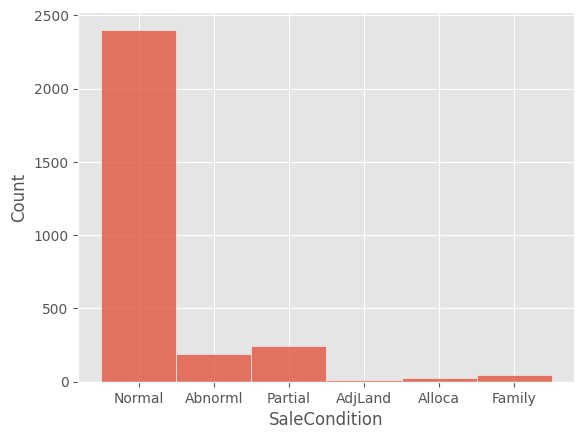

In [325]:
col_analytics('SaleCondition', True)

In [326]:
col_2_reshape_2encoding = ['Fireplaces', 'FireplaceQu', 'HeatingQC', 'BsmtFullBath', 'KitchenQual', 
'GarageCars', 'PavedDrive', 'OpenPorchSF', 'WoodDeckSF', 'HalfBath', 'SaleCondition']

col_2_encoding = ['GarageType', 'GarageFinish', 'MoSold', 'YrSold']

Нормализация и перекодирование

In [327]:
# перекодирование на 1 и 0

# Перекодирование колонки 'Fireplaces' на 1 или 0
subm_df['Fireplaces'] = subm_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Перекодирование колонки 'HeatingQC' на 1 или 0
subm_df['HeatingQC'] = subm_df['HeatingQC'].apply(lambda x: 1 if x in ['Ex'] else 0)
# Перекодирование колонки 'HeatingQC' на 1 или 0
subm_df['BsmtFullBath'] = subm_df['BsmtFullBath'].apply(lambda x: 1 if x in [1, 2] else 0)

subm_df['SaleCondition'] = recode_category('SaleCondition', 0.05, subm_df)


# label coding

# Перекодирование колонки 'FireplaceQu'
FireplaceQu_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['FireplaceQu'] = subm_df['FireplaceQu'].map(FireplaceQu_mapping)
# subm_df['FireplaceQu'] = subm_df['FireplaceQu'].apply(lambda x: 1 if x in ['Gd', 'Ex'] else 0)

# Перекодирование колонки 'KitchenQual'
kitchenqual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['KitchenQual'] = subm_df['KitchenQual'].map(kitchenqual_mapping)

# Оставить только значения 'Attchd' и 'Detchd', остальные заменить на 'Other'
garage_mapping = {'Attchd': 'Attchd', 'Detchd': 'Detchd', 'BuiltIn': 'Other', 'Basment': 'Other',
    '2Types': 'Other', 'CarPort': 'Other'}
subm_df['GarageType'] = subm_df['GarageType'].map(garage_mapping)


# Перекодирование колонки 'GarageCars' на 1 или 0
subm_df['GarageCars'] = subm_df['GarageCars'].apply(lambda x: 1 if x == 1 else 2 if x == 2 else 3 if x > 2 else 0)
# Перекодирование колонки 'OpenPorchSF' на 1 или 0
subm_df['OpenPorchSF'] = subm_df['OpenPorchSF'].apply(lambda x: 0 if x == 0 else 1)
# # Перекодирование колонки 'WoodDeckSF' на 1 или 0
# subm_df['WoodDeckSF'] = subm_df['WoodDeckSF'].apply(lambda x: 0 if x == 0 else 1)


In [328]:
# one-hot encoding
subm_df = pd.get_dummies(subm_df, columns=col_2_encoding)
# # Применяем StandartScaler: после его применения у всех колонок среднее станет равно 0, стандартное отклонение 1
# ss_scaler = StandardScaler()
# subm_df[col_2_normalize] = ss_scaler.fit_transform(subm_df[col_2_normalize])

In [329]:
bsmt_qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
subm_df['BsmtQual'] = subm_df['BsmtQual'].map(bsmt_qual_mapping)
exter_qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['ExterQual'] = subm_df['ExterQual'].map(exter_qual_mapping)
exter_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['ExterCond'] = subm_df['ExterCond'].map(exter_cond_mapping)
heating_qc_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
subm_df['HeatingQC'] = subm_df['HeatingQC'].map(heating_qc_mapping)
subm_df['LotFrontage']=subm_df['LotFrontage'].fillna(subm_df['LotFrontage'].mean())
subm_df['BsmtQual']=subm_df['BsmtQual'].fillna(subm_df['BsmtQual'].mode()[0])
# subm_df.drop(['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Neighborhood', 'Heating'], axis=1, inplace=True)


columns_to_transform = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType',
                        'RoofStyle', 'MasVnrArea', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2']
for col in columns_to_transform:
    most_frequent_value = subm_df[col].mode()[0]
    subm_df[col] = subm_df[col].apply(lambda x: 1 if x == most_frequent_value else 0)

# columns_to_normalize = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
#                         'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtFinSF1',
#                         'BsmtUnfSF', 'TotalBsmtSF','BsmtQual','HeatingQC']



columns_to_transform = ['HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1']

for column in columns_to_transform:
    value_counts = df[column].value_counts()
    most_popular_value = value_counts.index[0]
    second_popular_value = value_counts.index[1]
    subm_df[column] = subm_df[column].apply(lambda x: 2 if x == most_popular_value else (1 if x == second_popular_value else 0))

In [330]:
col_2_normalize = ['FullBath', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
                   'BedroomAbvGr', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                        'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtFinSF1',
                        'BsmtUnfSF', 'TotalBsmtSF','BsmtQual','HeatingQC']

for col in col_2_normalize:
    subm_df[col] = (subm_df[col] - subm_df[col].min()) / (subm_df[col].max() - subm_df[col].min())

In [331]:
subm_df.shape

(2919, 71)

In [332]:
subm_df.dtypes.to_list()

[dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool'),
 dtype('bool')

In [333]:
X_train=subm_df.iloc[:1460,:]
X_test=subm_df.iloc[1460:,:]
# df_Test.drop(['SalePrice'],axis=1,inplace=True)
# X_train=df_Train.drop(['SalePrice'],axis=1)
# y_train=df_Train['SalePrice']

In [334]:
X_train.shape, X_test.shape

((1460, 71), (1459, 71))

### Модель

In [335]:
regressor=xgboost.XGBRegressor()
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [336]:
n_estimators = [100, 200, 300]
max_depth = [2, 3, 5, 7]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
# min_child_weight=[1,2,3,4]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    # 'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [337]:
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_squared_error',
            n_jobs = -1,
            verbose = 5,
            return_train_score = True,
            random_state=42)

In [338]:
X_train.shape, X_test.shape

((1460, 71), (1459, 71))

In [339]:
X_train.dtypes.unique(), X_test.dtypes.unique()

(array([dtype('int64'), dtype('float64'), dtype('O'), dtype('bool')],
       dtype=object),
 array([dtype('int64'), dtype('float64'), dtype('O'), dtype('bool')],
       dtype=object))

In [340]:
# надо разобраться, так делать нельзя
X_train = X_train.select_dtypes(include = ['float64', 'int64', 'bool'])
X_test = X_test.select_dtypes(include = ['float64', 'int64', 'bool'])

In [341]:
X_train.shape, X_test.shape

((1460, 70), (1459, 70))

In [345]:
y_train_log = np.log(y_train)

In [353]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.15, max_depth=3, n_estimators=200;, score=(train=-1154721222.593, test=-729235347.748) total time=   0.4s
[22:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } 

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 7],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=5)

In [354]:
from sklearn.metrics import mean_squared_error
def get_score(model, X, y):
    model.fit(X, y.ravel())

    # Получаем предсказания на тестовых данных
    y_pred = (model.predict(X))
    # y_pred = np.exp(model.predict(X))

    # Вычисляем среднеквадратическую ошибку (MSE)
    mse = mean_squared_error(y, y_pred)

    # Получаем корень из MSE, чтобы получить RMSE
    rmse = np.sqrt(mse)

    return f'Значение метрики RMSE: {rmse}'

In [355]:
get_score(random_cv, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[CV 4/5] END base_score=0.75, booster=gblinear, learning_rate=0.15, max_depth=3, n_estimators=200;, score=(train=-1134142333.854, test=-809829253.467) total time=   0.4s
[22:55:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } 

'Значение метрики RMSE: 10771.77631670705'

In [397]:
X_test.shape, X_train.shape

((1459, 70), (1460, 70))

In [356]:
y_pred = (random_cv.predict(X_test))

In [357]:
y_pred.mean()

177660.25

In [392]:
# 16191/y_train.mean()

0.08949200186476405

In [372]:
# df_last_40.shape

In [373]:
# df_last_40.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [374]:
# Сохраняем DataFrame в CSV-файл
# df_last_40.to_csv('subm_df_last_40.csv', index=False)

In [375]:
# df_num = df.select_dtypes(include = ['float64', 'int64'])
# df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [358]:
def res_2_csv(id_column, predictions_column, file_name='submission.csv'):
    # Создаем DataFrame из переданных столбцов
    df = pd.DataFrame({ 'Id': id_column, 'SalePrice': predictions_column })
    # Сохраняем DataFrame в CSV-файл
    df.to_csv(file_name, index=False)

# # res_2_csv(test['Id'], y_hat)

In [359]:
res_2_csv(X_test['Id'], y_pred)